In [3]:
import os
import h5py    
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2
import nrrd
from tifffile import tifffile
import json
from pprint import pprint
import math

In [ ]:
filepath='/net/birdstore/Vessel/WBIM/Acquisition/LifeCanvas/003_20240209/00005/Scan/00060_00089/00000/tile.h5'

In [ ]:
if os.path.exists(filepath):
    f = h5py.File(filepath, 'r')
    for key in f.keys():
        print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
        print(type(f[key])) # get the object type: usually group or dataset

    #Get the HDF5 group; key needs to be a group name from above
    group = f['CH1']
    print(type(group))
    #Checkout what keys are inside that group.
    for key in group.keys():
        print(key)
    data = group['raw'][()]
    print(f'dtype={data.dtype} shape={data.shape}')


In [ ]:
if os.path.exists(filepath):
    plt.rcParams["figure.figsize"] = [14, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.imshow(data[125,:,:], cmap='seismic')
    #plt.show()

In [ ]:
#filepath = '/home/eddyod/programming/ITKMontage/examples/SampleData_CMUrun2/tile_10.nrrd'
#filepath = '/home/eddyod/programming/ITKMontage/examples/SampleData_DzZ_T1/tile_10.nrrd'
#if os.path.exists(filepath):
#    data, header = nrrd.read(filepath)
#    print(data.dtype, readdata.shape)

In [11]:
# numpy is z,y,x, rows, columns
# matlab data is in [y, x, z] coordinates. 
# identify TIFF x=102, y=154 with 250 files
dirpath = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK20230126-003/preps/C1/registration'
filepath = os.path.join(dirpath, 'layers.1-5.tif')
if os.path.exists(filepath):
    data = tifffile.imread(filepath)
    #data = np.swapaxes(data, 0, 2)
    #data = np.swapaxes(data, 0, 1)
    print(data.dtype, data.shape, data.ndim)

uint16 (250, 2221, 2802) 3


In [19]:
i = 249
str(i).zfill(3) + '.tif'

'249.tif'

In [20]:
outpath = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK20230126-003/preps/C1/sections'
sections = data.shape[0]
for i in range(0,sections-1):
    arr = data[i, :, :]
    filename = str(i).zfill(3)  + '.tif'
    outfile = os.path.join(outpath, filename)
    io.imsave(outfile, arr)

In [ ]:
if os.path.exists(filepath):
    arr = data[0,:,:]
    arr.dtype, arr.shape, arr.ndim

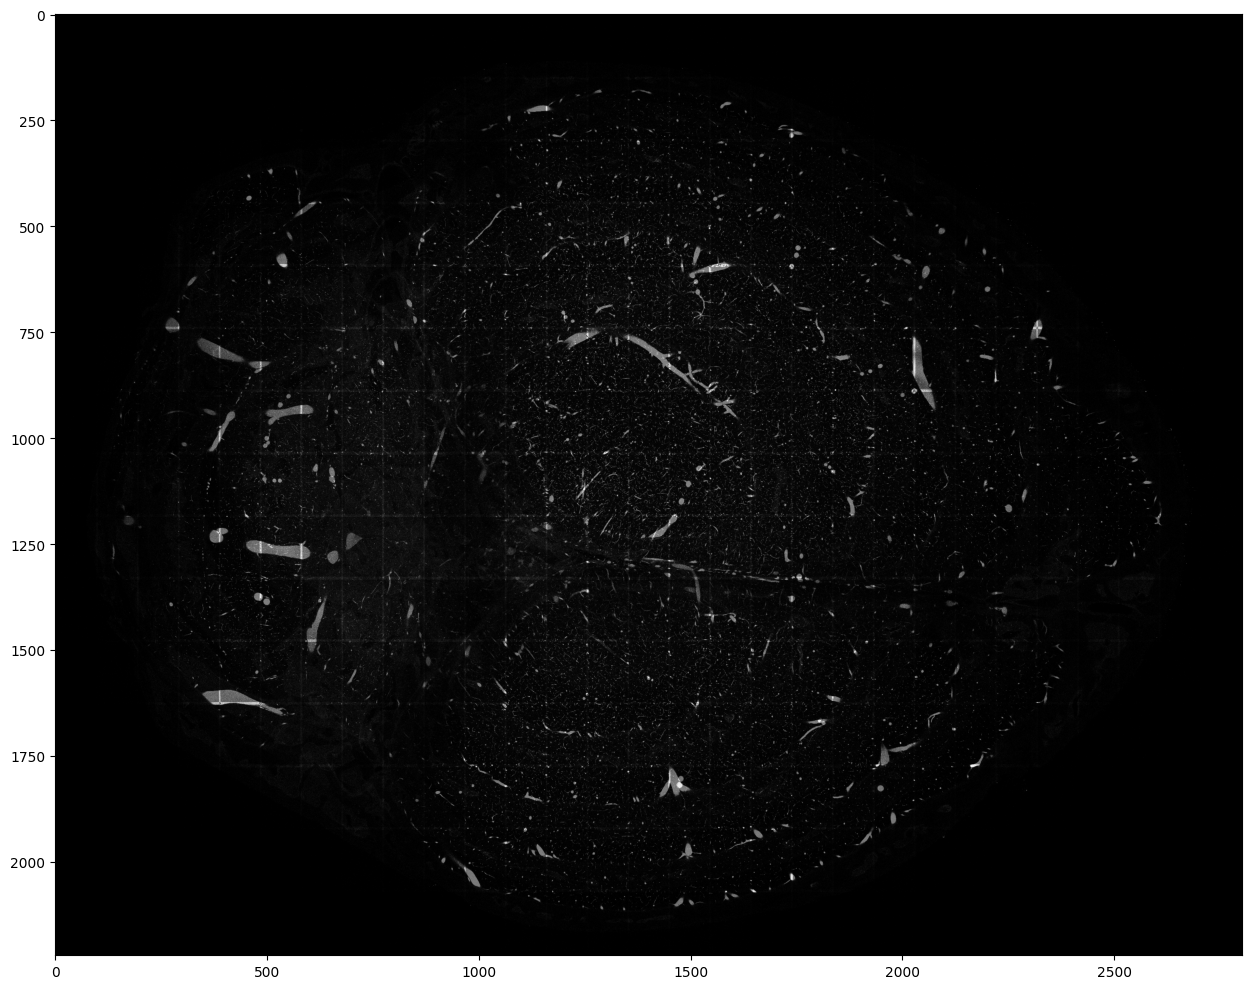

In [14]:
plt.rcParams["figure.figsize"] = [14, 10]
plt.rcParams["figure.autolayout"] = True
plt.imshow(data[225,:,:], cmap='gray')

In [ ]:
INPUT = ''
infopath = os.path.join(INPUT, 'info')
infos = sorted(os.listdir(infopath))
print(f'found {len(infos)} info.json files')

In [ ]:
bbox_mmxx_um = []
bbox_mmxx_pxl = []
layer_z_um = []
stitch_tiles = []
for file in sorted(infos):
    inpath = os.path.join(infopath, file)
    with open(inpath) as json_data:
        d = json.load(json_data)
        stitch_tiles.append(d)
        json_data.close()
        print('Box size of ', file, end="\t")
        print(d['vol_bbox_z_mx_um'])
        dl = d['tile_mmxx_pxl']
        y_min, x_min, y_max, x_max = dl
        height = y_max - y_min
        width = x_max - x_min
        print(f'height={height}, width={width}')
        #print(dl)
        bbox_mmxx_um.append(d['tile_mmxx_um'])
        bbox_mmxx_pxl.append(d['tile_mmxx_pxl'])
        layer_z_um.append(d['layer_z_um'])

# set to np arrays
bbox_mmxx_um = np.array(bbox_mmxx_um)


1. layer_z_um is the z position of the first plane in micrometer. 
2. tile_mmxx_pxl is the bounding box of the 2D image [y_min, x_min, y_max, x_max] in pixel.

In [ ]:
TIFPATH = os.path.join(INPUT, 'tif')
tiles = sorted(os.listdir(TIFPATH))
# Parameters
scaling_factor = 10
stitch_voxel_size_um = [0.375*scaling_factor, 0.375*scaling_factor, 1];
stack_size_um = stitch_tiles[0]['stack_size_um'];
print('stack_size_um', stack_size_um)
stack_size = stitch_tiles[0]['stack_size'];
ds_stack_size = [round(stack/stitch) for stack,stitch in zip(stack_size_um, stitch_voxel_size_um)]
print('ds_stack_size', ds_stack_size)


vol_bbox_z_mx_um = [56770, 56770, 249]
vol_bbox_mm_um = np.min(bbox_mmxx_um,0)[0:2].tolist()
vol_bbox_xx_um = np.max(bbox_mmxx_um,0)[2:4].tolist()
vol_bbox_mm_um.append(vol_bbox_z_mx_um[0])
vol_bbox_xx_um.append(vol_bbox_z_mx_um[1])
print('vol_bbox_mm_um', vol_bbox_mm_um)
print('vol_bbox_xx_um', vol_bbox_xx_um)

vol_bbox_ll_um = [a_i - b_i for a_i, b_i in zip(vol_bbox_xx_um, vol_bbox_mm_um)]
vol_bbox_ll_um = [a+1 for a in vol_bbox_ll_um]

print('vol_bbox_ll_um', vol_bbox_ll_um)
ds_bbox_ll = (np.array(vol_bbox_ll_um) / stitch_voxel_size_um)
ds_bbox_ll = [math.ceil(a) for a  in ds_bbox_ll]
#ds_bbox_ll = (np.array(vol_bbox_ll_um) / stitch_voxel_size_um)
ds_bbox_ll[2] = 250
b = ds_bbox_ll
ds_bbox_ll = [b[2], b[0], b[1]]
print('ds_bbox_ll', ds_bbox_ll)

In [ ]:
0.325 * 32

In [ ]:
# properties are in [y, x, z] coordinates. 
# numpy is [z,y,x]
#ds_bbox_ll = [250, 1335, 1356]
assert len(infos) == len(tiles), "Error, number of tiles does not equal number of json files"
tmp_stitch_data = np.zeros(ds_bbox_ll, dtype=np.uint16)
print(f'Big box shape={tmp_stitch_data.shape}')



for info,tile in zip(stitch_tiles, tiles):
    tifpath = os.path.join(TIFPATH, tile)
    tif = io.imread(tifpath)
    #tif = np.swapaxes(tif, 0, 2)
    #tif = np.swapaxes(tif, 0, 1)
    
    tmp_tile_bbox_mm_um = info['tile_mmxx_um'][:2]
    tmp_tile_bbox_mm_um.append(info['layer_z_um'])
    tmp_tile_bbox_ll_um = info['tile_mmll_um'][2:]
    tmp_tile_bbox_ll_um.append(info['stack_size_um'][2])
    tmp_tile_ll_ds_pxl = [round(bbox/voxel) for bbox,voxel in zip(tmp_tile_bbox_ll_um, stitch_voxel_size_um)]
    print(f'TIF shape= {tif.shape}', end="\t" )
    print('bounding box', tmp_tile_ll_ds_pxl, end="\t")
    
    # Local bounding box 
    tmp_local_bbox_um = [a_i - b_i for a_i, b_i in zip(tmp_tile_bbox_mm_um, vol_bbox_mm_um)]
    #tmp_local_bbox_mm_ds_pxl = round(tmp_local_bbox_um ./ stitch_voxel_size_um);
    tmp_local_bbox_mm_ds_pxl = [round(a/b) for a,b in zip(tmp_local_bbox_um, stitch_voxel_size_um)]
    #print(tmp_local_bbox_mm_ds_pxl)
    start_row = tmp_local_bbox_mm_ds_pxl[0]
    start_col = tmp_local_bbox_mm_ds_pxl[1]
    end_row = tif.shape[1] + start_row
    end_col = tif.shape[2] + start_col
    print(start_row, end_row, start_col, end_col)
    tmp_stitch_data[0:, start_row:end_row, start_col:end_col] += tif
    
    continue
    # Deal with edge: 
    tmp_local_bbox_mm_ds_pxl = np.max(tmp_local_bbox_mm_ds_pxl, axis=0)
    # tmp_local_bbox_xx_ds_pxl = tmp_local_bbox_mm_ds_pxl + tmp_tile_ll_ds_pxl - 1;

    tmp_local_bbox_xx_ds_pxl = [a + tmp_local_bbox_mm_ds_pxl for a in tmp_tile_ll_ds_pxl]
    tmp_local_bbox_xx_ds_pxl = [a-1 for a in tmp_local_bbox_xx_ds_pxl]

    # Max - rendering
    """
    tmp_stitch_data(tmp_local_bbox_mm_ds_pxl[0] : tmp_local_bbox_xx_ds_pxl[0], 
        tmp_local_bbox_mm_ds_pxl[1] : tmp_local_bbox_xx_ds_pxl[1], 
        tmp_local_bbox_mm_ds_pxl[2] : tmp_local_bbox_xx_ds_pxl[2]) = max(tmp_stitch_data(
        tmp_local_bbox_mm_ds_pxl[0] : tmp_local_bbox_xx_ds_pxl[0], 
        tmp_local_bbox_mm_ds_pxl[1] : tmp_local_bbox_xx_ds_pxl[1], 
        tmp_local_bbox_mm_ds_pxl[2] : tmp_local_bbox_xx_ds_pxl[2]), tmp_tile_data);
    """
#outpath = '/home/eddyod/tmp/stitched.tif'
#tmp_stitch_data = np.swapaxes(tmp_stitch_data, 0, 2)

#io.imsave(outpath, tmp_stitch_data)
#print(f'dtype={tmp_stitch_data.dtype} shape={tmp_stitch_data.shape}')
#print('saved', outpath)

In [ ]:
from pathlib import Path

base_path = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK20230126-003/preps/C1/layers'
available_layers = [1,2,3]
all_info_files = {}
for layer in available_layers:
    layer = str(layer).zfill(5)
    infopath = os.path.join(base_path, layer, 'info')
    infos = sorted(os.listdir(infopath))
    print(f'found {len(infos)} info.json files')
    for file in sorted(infos):
        inpath = os.path.join(infopath, file)
        with open(inpath) as json_data:
            d = json.load(json_data)
            f = Path(file).stem
            all_info_files[(layer,f)] = d
            json_data.close()
    print(f'len of all infos={len(all_info_files)}')

In [ ]:
k = ('00001','00058_00095')
all_info_files

In [ ]:
first = next(iter(all_info_files.values()))
first['stack_size_um']

In [ ]:
max(st['layer_z_um'] for st in all_info_files.values())

In [7]:
base_path = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK20230126-003/preps/C1/layers'
max_layer = max([int(layer) for layer in sorted(os.listdir(base_path))])
outfile = 'layers.1-' + str(max_layer)  + '.tif'
print(outfile)    

layers.1-5.tif


In [8]:
output_path = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK20230126-003/preps/C1/layers/00005/h5/00060_00089.h5'
input_path = '/net/birdstore/Vessel/WBIM/Acquisition/LifeCanvas/003_20240209/00005/Scan/00060_00089/00000/tile.h5'
relative_input_path = os.path.relpath(input_path, os.path.dirname(output_path))

In [10]:
os.symlink(input_path, output_path)